The goal of this notebook is to load pre-processed carbon stock datasets, standardize units and spatial resolution, and mosaic together into layers that provide wall-to-wall carbon stock metrics for the y2y region.

In [1]:
# load packages
import geopandas as gpd
import rasterio
from rasterio.warp import Resampling
import rioxarray
import xarray
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [2]:
# define print raster function to help compare reprojections
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
        f"NoDataValue: {raster.rio.nodata}\n"
        f"NoDataOriginalValues: {raster.rio.encoded_nodata}\n"
    )

### The first map is a combination of Sothe canada layers and CMS CONUS Forest Carbon Stock layers.

In [3]:
# set clipped layers directory
carbon_dir = './carbon_stock_data/final_layers_clipped'

# set Sothe carbon stock layers filepaths
forest_c_canada_dir = carbon_dir + '/forest_carbon_kg_m2_sothe.tif'
soc_canada_dir = carbon_dir + '/soc_0_1m_kg_m2_sothe.tif'

# set CMS CONUS carbon stock layers filepaths
agb_conus_dir = carbon_dir + '/agb_mg_ha_cms_2015_2017.tif'
bgb_conus_dir = carbon_dir + '/bgb_mg_ha_cms_2015_2017.tif'
deadagb_conus_dir = carbon_dir + '/deadagb_mg_ha_cms_2015_2017.tif'
deadbgb_conus_dir = carbon_dir + '/deadbgb_mg_ha_cms_2015_2017.tif'
litter_conus_dir = carbon_dir + '/litter_mg_ha_cms_2015_2017.tif'
soc_conus_dir = carbon_dir + '/soc_mg_ha_cms_2015_2017.tif'

In [4]:
# load a single raster from each and assess spatial resolution and projection
sothe_ex = xarray.open_dataarray(soc_canada_dir)
cms_ex = xarray.open_dataarray(agb_conus_dir)

In [5]:
print_raster(sothe_ex)
print_raster(cms_ex)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 762864064.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (11354, 14747)
resolution: (100.0, -100.0)
bounds: (-2471945.0, 2174605.0, -997245.0, 3310005.0)
sum: 24123142144.0
CRS: EPSG:5070
NoDataValue: nan
NoDataOriginalValues: -999.0



In [6]:
# first we need to add together all the forest carbon layers from CMS (since the Sothe layers are together)
# load all the forest carbon layers
cms_forest_dir = [agb_conus_dir, bgb_conus_dir, deadagb_conus_dir, deadbgb_conus_dir, litter_conus_dir]

for i in range(0, len(cms_forest_dir)):
    if i == 0:
        cms_forest_c = xarray.open_dataarray(cms_forest_dir[i])
    else:
        cms_forest_c += xarray.open_dataarray(cms_forest_dir[i])

print_raster(cms_forest_c)

shape: (11354, 14747)
resolution: (100.0, -100.0)
bounds: (-2471945.0, 2174605.0, -997245.0, 3310005.0)
sum: 40878043136.0
CRS: EPSG:5070
NoDataValue: nan
NoDataOriginalValues: -999.0



In [7]:
# # plot cms forest carbon to make sure still looks right
# fig, ax = plt.subplots(ncols=1, figsize=(12,4))
# cms_forest_c.plot(ax=ax)
# plt.draw()

In [8]:
# load sothe forest c
sothe_forest_c = xarray.open_dataarray(forest_c_canada_dir)

In [ ]:
# reproject cms forest carbon to match sothe projection and resolution
# resample taking the average
cms_forest_c_reproj = cms_forest_c.rio.reproject_match(sothe_forest_c, resampling = Resampling.average)

In [10]:
# review raster stats
print_raster(sothe_forest_c)
print_raster(cms_forest_c_reproj)

shape: (11385, 14576)
resolution: (0.00224599624135848, -0.0022459534258844607)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 100289472.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (11385, 14576)
resolution: (0.00224599624135848, -0.002245953425884461)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 9531610112.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -999.0



In [11]:
# # plot the two
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))
# sothe_forest_c.plot(ax=axes[0])
# cms_forest_c_reproj.plot(ax=axes[1])
# plt.draw()

In [12]:
# assign coords to make coordinates the exact same (can be tiny differences)
cms_forest_c_reproj = cms_forest_c_reproj.assign_coords({
    "x": sothe_forest_c.x,
    "y": sothe_forest_c.y,
})

In [13]:
# convert sothe data to t/ha
sothe_forest_c_t_ha = sothe_forest_c * 10

print_raster(sothe_forest_c_t_ha)

# multiply cms data by scaling factor
cms_forest_c_reproj_t_ha = cms_forest_c_reproj * 0.1

print_raster(cms_forest_c_reproj_t_ha)


shape: (11385, 14576)
resolution: (0.00224599624135848, -0.0022459534258844607)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 1002892928.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None

shape: (11385, 14576)
resolution: (0.00224599624135848, -0.0022459534258844607)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 953161856.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None



In [14]:
# # plot the two
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))
# sothe_forest_c_t_ha.plot(ax=axes[0])
# cms_forest_c_reproj_t_ha.plot(ax=axes[1])
# plt.draw()

In [15]:
# merge sothe and cms raster
# combine_first accounts for NaN values in the first array and fills with values from the second
forest_c_merged = sothe_forest_c_t_ha.combine_first(cms_forest_c_reproj_t_ha)

In [16]:
# # plot the merged raster
# forest_c_merged.plot()
# plt.draw()

In [17]:
# export raster
forest_c_merged.rio.to_raster('./carbon_stock_data/output_layers/forest_c_t_ha.tif')

### The Second map is aboveground and belowground carbon stock from Spawn 2010

In [3]:
# load file path
carbon_dir = './carbon_stock_data/final_layers_clipped'

agb_spawn_dir = carbon_dir + '/agb_mg_ha_spawn_2010.tif'
bgb_spawn_dir = carbon_dir + '/bgb_mg_ha_spawn_2010.tif'

In [4]:
# load data arrays
agb_spawn = xarray.open_dataarray(agb_spawn_dir)
bgb_spawn = xarray.open_dataarray(bgb_spawn_dir)

In [6]:
# check attributes
print_raster(agb_spawn)
print_raster(bgb_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 8712377344.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 3599774464.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0



In [7]:
# convert to t/ha
agb_spawn_t_ha = agb_spawn * 0.1
bgb_spawn_t_ha = bgb_spawn * 0.1

In [8]:
# export final layers
agb_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/agb_c_spawn_t_ha.tif')
bgb_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/bgb_c_spawn_t_ha.tif')

### The Soil Organic Carbon Map is a combination of Sothe Canada data and openlandmap US data 0-1m depth

In [10]:
# load file path
carbon_dir = './carbon_stock_data/final_layers_clipped'

soc_sothe_dir = carbon_dir + '/soc_0_1m_kg_m2_sothe.tif'
soc_olm_dir = carbon_dir + '/soc_0_1m_kg_m2_openlandmap.tif'

In [11]:
# load data arrays
soc_sothe = xarray.open_dataarray(soc_sothe_dir)
soc_olm = xarray.open_dataarray(soc_olm_dir)

In [12]:
# print attributes
print_raster(soc_sothe)
print_raster(soc_olm)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 762864064.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (12274, 15713)
resolution: (0.0020833330000000006, -0.002083333)
bounds: (-141.035422901, 41.751257299, -108.30001147200001, 67.322086541)
sum: 1455630080.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -32768.0



In [14]:
# reproject olm to match sothe projection and resolution
# resample taking the average
soc_olm_reproj = soc_olm.rio.reproject_match(soc_sothe, resampling = Resampling.average)

In [16]:
# print attributes
print_raster(soc_sothe)
print_raster(soc_olm_reproj)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 762864064.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (11386, 14570)
resolution: (0.0022457898480768247, -0.0022457903991559697)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 1263547520.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -32768.0



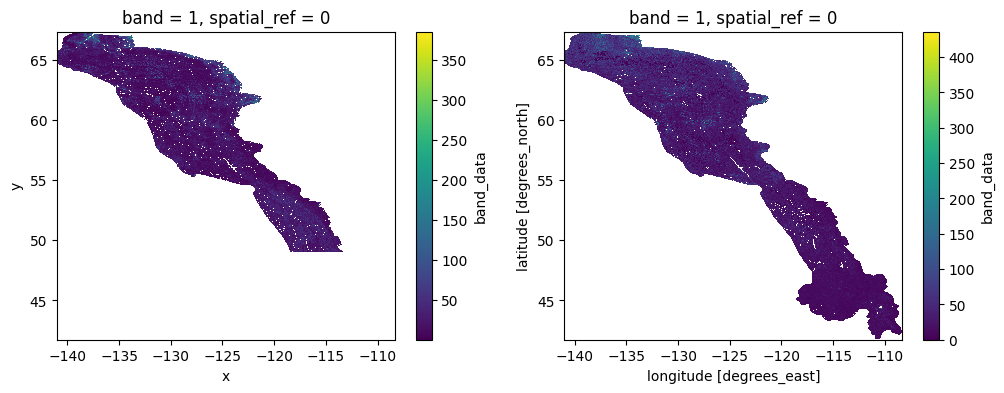

In [17]:
# plot the two
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
soc_sothe.plot(ax=axes[0])
soc_olm_reproj.plot(ax=axes[1])
plt.draw()

In [18]:
# combine datasets, defaulting to Sothe values
soc_0_1m_kg_m2 = soc_sothe.combine_first(soc_olm_reproj)

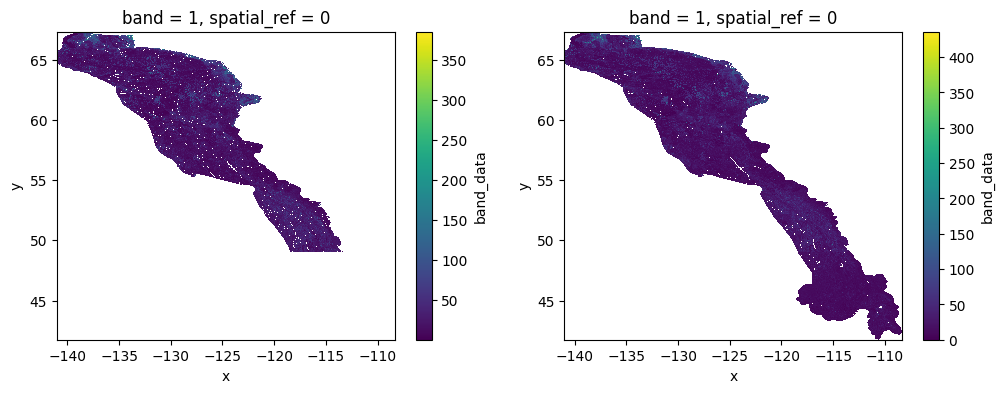

In [19]:
# plot the two
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
soc_sothe.plot(ax=axes[0])
soc_0_1m_kg_m2.plot(ax=axes[1])
plt.draw()

In [20]:
# convert to t/ha
soc_0_1m_t_ha = soc_0_1m_kg_m2 * 10

In [21]:
# export raster
soc_0_1m_t_ha.rio.to_raster('./carbon_stock_data/output_layers/soc_0_1m_t_ha.tif')